In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")


In [4]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded["Churn_Yes"] = df_encoded["Churn_Yes"].astype(int)

/tmp/ipython-input-284713015.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [6]:
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [9]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train_resampled)

y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

In [10]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [15]:
print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))

print("\nRandom Forest Report:\n")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))


Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1035
           1       0.54      0.63      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.77      1409

ROC-AUC: 0.812441551060477
F1-Score: 0.5834363411619283

Random Forest Report:

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.57      0.60      0.58       374

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC: 0.8220504275491488
F1-Score: 0.5845347313237221


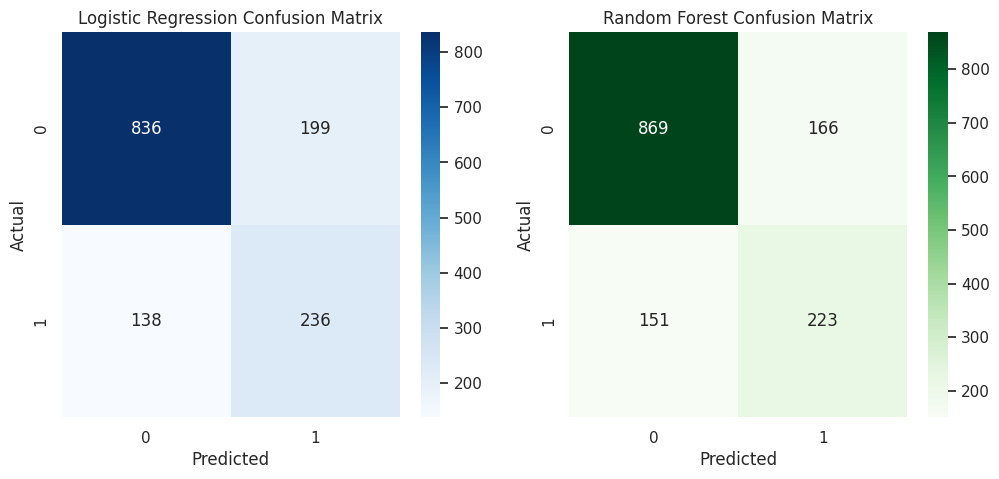

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

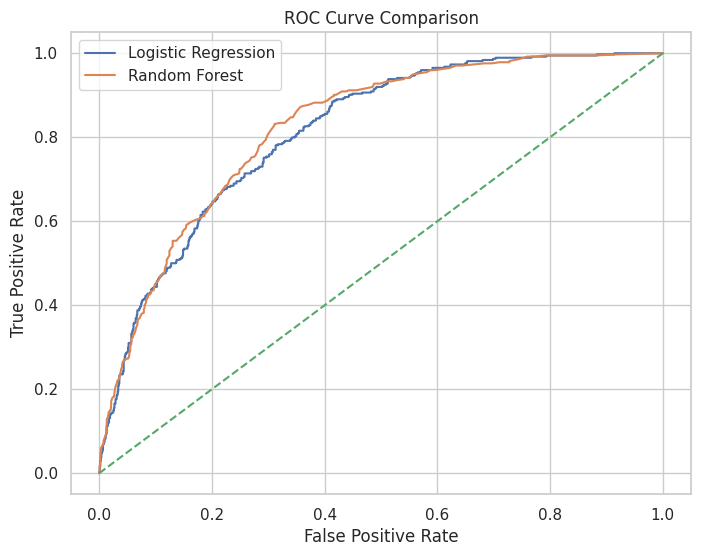

In [13]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


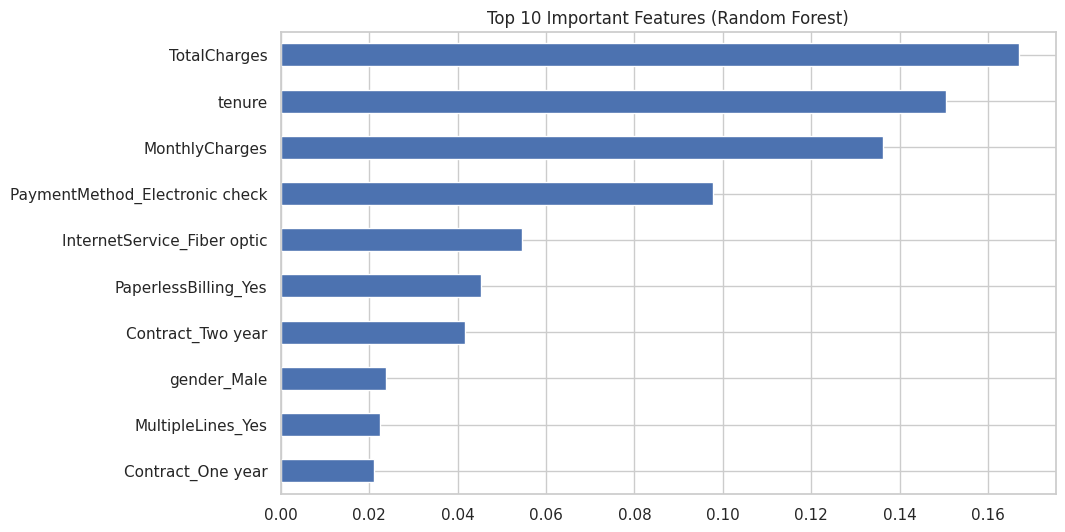

In [14]:
feature_importances = pd.Series(
    rf_model.feature_importances_, index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind="barh")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()